In [28]:
import pandas as pd
import seaborn as sns
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt

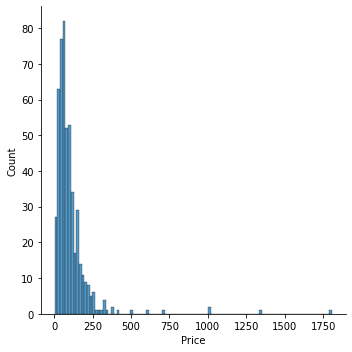

In [23]:

data = pd.read_csv('constituents-financials_csv.csv')
sns.displot(data.Price, kde=False)


/home/vloginov/anaconda3/envs/pandas/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


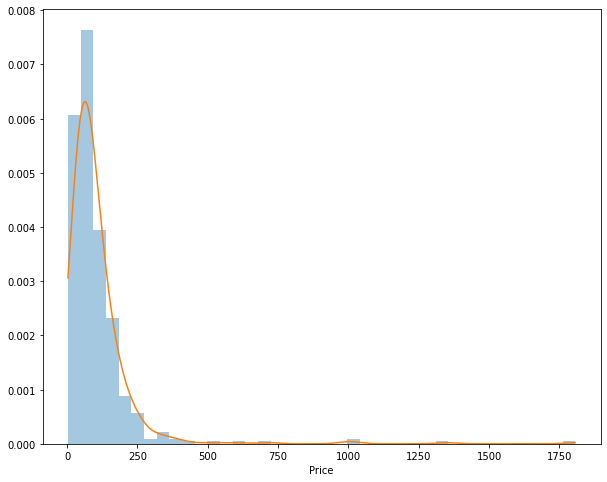

In [80]:
plt.figure(figsize=(10, 8))

kernel = st.gaussian_kde(data.Price)
print(kernel)
min_amount, max_amount = data.Price.min(), data.Price.max()
x = np.linspace(min_amount, max_amount, len(data.Price))
kde_values = kernel(x)

sns.distplot(data.Price, kde=False, bins=40, norm_hist=True, label=f'Average price in dollars')
plt.plot(x, kde_values)

iqr 70.29
1/4 quantile 46.25 3/4 quantile 116.54
min -59.185 max 151.685
median 73.92


<AxesSubplot:>

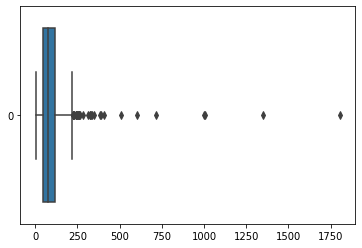

In [148]:
price = data.Price
# price = price[price.between(price.min(), price.quantile(.99))].reset_index(drop=True)

q1 = price.quantile(0.25)
q3 = price.quantile(0.75)
iqr =  q3 -  q1
print('iqr', iqr)
print('1/4 quantile', price.quantile(1/4), '3/4 quantile', price.quantile(3/4))
print('min', q1-1.5*iqr, 'max', q1+1.5*iqr)
print('median', price.median())
sns.boxplot(data=price, orient='h')

4.30537206085582 3.953849741927409


/home/vloginov/anaconda3/envs/pandas/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/vloginov/anaconda3/envs/pandas/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


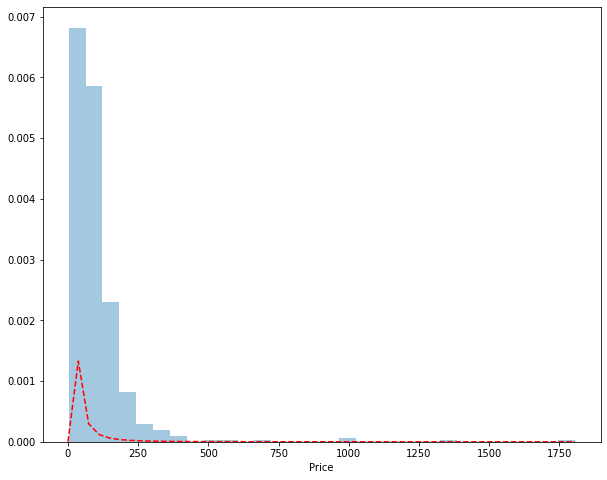

In [157]:
from scipy.stats import lognorm
plt.figure(figsize=(10, 8))

est_mu = np.log(price).mean()
est_sigma_sq = np.log(price - est_mu**2).mean()
print(est_mu, est_sigma_sq)

sns.distplot(price, kde=False, bins=30, norm_hist=True, label=f'Average price in dollars')
x = np.linspace(0, price.max())

plt.plot(x, lognorm.pdf(x, s=est_sigma_sq**0.5, loc=est_mu), 'r--')
plt.show()